# heatmaps
with Formula 1 data from https://ergast.com/mrd/db

In [1]:
%autosave 0
%load_ext autoreload
%autoreload 2

from tools import DATADIR, F1_ZIPPED
from etl.ergast import ErgastF1
from viz.plot import Plot

f1 = ErgastF1(F1_ZIPPED)
plot = Plot('dark_background')
folder = DATADIR / 'plots'
season = 2019

Autosave disabled


## lights out

In [2]:
qtimes = (
    f1.qualifying
    .join(f1.drivers['driver'], on='id_driver')
    .join(f1.races['id_circuit round season'.split()], on='id_race')
    .join(f1.circuits['circuit'], on='id_circuit')
    .assign(seconds = lambda df: df['q1 q2 q3'.split()].min(axis=1))
    ['season round circuit driver pos seconds'.split()]
    .sort_values('season round pos'.split()).reset_index(drop=True)
)
qtimes

,season,round,circuit,driver,pos,seconds
0,1994,1,Autódromo José Carlos Pace,Ayrton Senna,1,75.962
1,1994,1,Autódromo José Carlos Pace,Michael Schumacher,2,76.290
2,1994,1,Autódromo José Carlos Pace,Jean Alesi,3,77.385
3,1994,1,Autódromo José Carlos Pace,Damon Hill,4,77.554
4,1994,1,Autódromo José Carlos Pace,Heinz-Harald Frentzen,5,77.806
...,...,...,...,...,...,...
8349,2019,21,Yas Marina Circuit,Romain Grosjean,16,98.051
8350,2019,21,Yas Marina Circuit,Antonio Giovinazzi,17,98.114
8351,2019,21,Yas Marina Circuit,Kimi Räikkönen,18,98.383
8352,2019,21,Yas Marina Circuit,George Russell,19,98.717


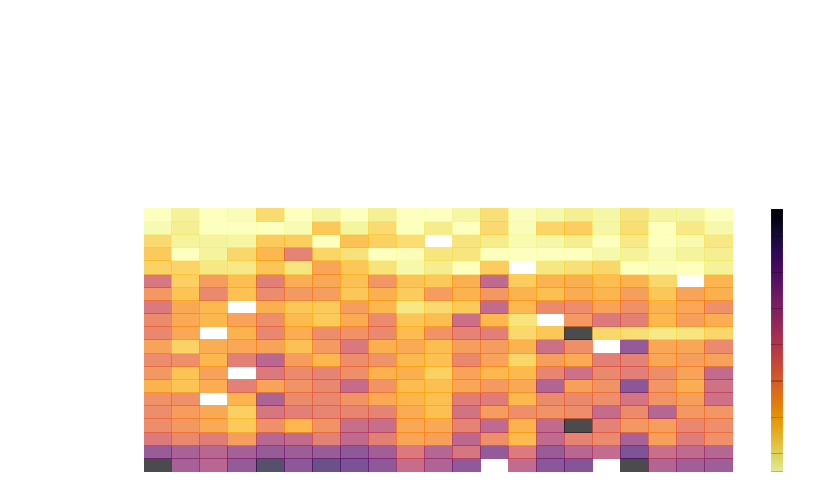

In [3]:
def qfactor(data, season, limit=1.07, **kwargs):
    kwargs.setdefault('cmap', 'inferno_r')
    kwargs.setdefault('colorbar', True)
    kwargs.setdefault('title', f"{season} qualifying time / pole time")
    
    data = data[data['season'].eq(season)]
    circuits = data['circuit'].unique()
    data = data.pivot(index='driver', columns='circuit', values='seconds')
    data = data[circuits]
    data = data.div(data.min(axis=0), axis=1).clip(upper=limit)
    data = data.loc[data.mean(axis=1).sort_values().index]
    
    return plot.heat(data, **kwargs)

path = folder / f"lights_out_{season}.png"
qfactor(qtimes, season).figure.savefig(path)

## away we go

In [4]:
starts = (
    f1.lap_times[lambda df: df['lap'].eq(1)]
    .join(f1.drivers['driver'], on='id_driver')
    .join(f1.races['id_circuit round season'.split()], on='id_race')
    .join(f1.circuits['circuit'], on='id_circuit')
    ['season round circuit driver pos seconds'.split()]
    .sort_values('season round pos'.split()).reset_index(drop=True)
)
starts

,season,round,circuit,driver,pos,seconds
0,1996,1,Albert Park Grand Prix Circuit,Jacques Villeneuve,1,103.702
1,1996,1,Albert Park Grand Prix Circuit,Damon Hill,2,104.243
2,1996,1,Albert Park Grand Prix Circuit,Eddie Irvine,3,104.981
3,1996,1,Albert Park Grand Prix Circuit,Michael Schumacher,4,105.188
4,1996,1,Albert Park Grand Prix Circuit,Jean Alesi,5,106.506
...,...,...,...,...,...,...
8954,2019,21,Yas Marina Circuit,Daniil Kvyat,16,115.917
8955,2019,21,Yas Marina Circuit,Romain Grosjean,17,116.282
8956,2019,21,Yas Marina Circuit,Robert Kubica,18,117.409
8957,2019,21,Yas Marina Circuit,George Russell,19,117.917


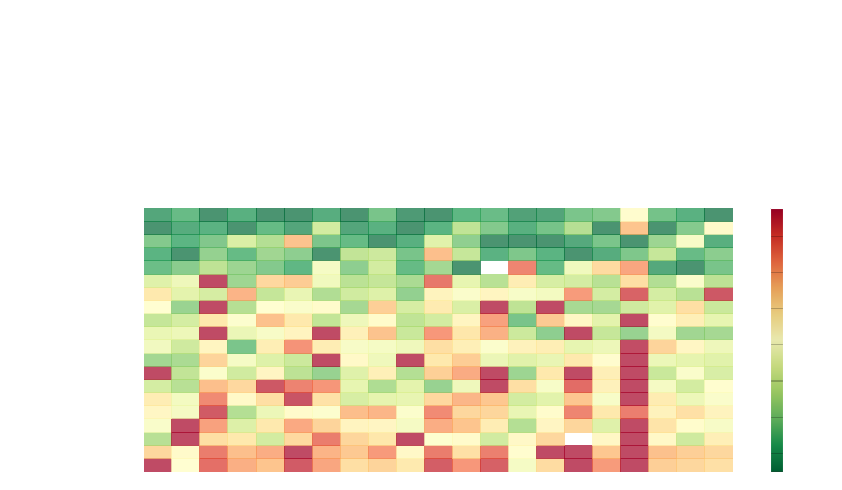

In [5]:
def firstlaps(data, season, limit=1.20, **kwargs):
    kwargs.setdefault('cmap', 'RdYlGn_r')
    
    axes = qfactor(data, season, limit=limit, **kwargs)
    axes.set_title(f"{season} first lap time / best time")
    return axes

path = folder / f"away_we_go_{season}.png"
firstlaps(starts, season).figure.savefig(path)

## over the line

In [6]:
data = qtimes.set_index('season circuit driver'.split())['seconds']
data /= data.groupby(level=[0,1]).min().rename('q_factor')
data = data.nlargest(10).reset_index()
data.index += 1
data

,season,circuit,driver,seconds
1,1995,Suzuka Circuit,Mark Blundell,10.228620
2,2016,Hungaroring,Rio Haryanto,1.377965
3,2016,Hungaroring,Pascal Wehrlein,1.342375
4,2016,Hungaroring,Marcus Ericsson,1.337885
5,2005,Albert Park Grand Prix Circuit,Michael Schumacher,1.335890
6,2004,Autodromo Enzo e Dino Ferrari,Zsolt Baumgartner,1.332853
7,2010,Circuit de Spa-Francorchamps,Lucas di Grassi,1.311747
8,2016,Hungaroring,Kevin Magnussen,1.307359
9,2016,Hungaroring,Felipe Massa,1.300556
10,2016,Hungaroring,Jolyon Palmer,1.300131
